- Extractive/Abstractive summarization 이해하기
- 단어장 크기를 줄이는 다양한 text normalization 적용해보기
- seq2seq의 성능을 Up시키는 Attention Mechanism 적용하기

### 시작전 NLTK의 불용어(stopwords) 설치   
LTK를 설치하고 NTLK의 데이터셋을 다운로드하기

```
$ pip install nltk
```

BeautifulSoup 라이브러리도 설치하지 않았다면 설치하기
```
$ pip install beautifulsoup4
```

#### NLTK는 Natural Language Toolkit
- 영어 기호, 통계, 자연어 처리를 위한 라이브러리
- LTK에는 I, my, me, over, 조사, 접미사와 같이 문장에는 자주 등장하지만, 의미를 분석하고 요약하는데는 거의 의미가 없는 100여개의 불용어가 미리 정리되어 있다. 
- 이를 이용해 다운로드받은 리뷰 파일에서 불용어를 제거하는 작업을 할것이다.



#  프로젝트: 뉴스기사 요약해보기
 제공된 데이터를 활용하여 추상적 요약과 추출적 요약해보자 

# 라이브러리 불러오기

In [194]:

import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj60/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 1. 데이터 수집하기(1)


데이터는 아래 링크에 있는 뉴스 기사 데이터(newssummarymore.csv)를 사용한다.    
https://github.com/sunnysai12345/News_Summary    
아래의 코드로 데이터를 다운로드 할 수 있다.

In [195]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98401


In [3]:
data.sample(5)

,headlines,text
2797,Scientists discover a process that stabilises ...,Researchers at Princeton Plasma Physics Labora...
53598,China to build AI development park worth over ...,China has released a plan to build a technolog...
31455,Told CSK coach I wanted to bat higher in IPL 2...,Indian Premier League side Chennai Super Kings...
52395,Zomato valued at $2.5 billion by Morgan Stanley,Restaurant discovery and food ordering startup...
77608,Maha farmers to fast indefinitely to protest l...,Farmers from 78 villages in Maharashtra are re...


text와 headlines 두 가지 열 존재    
추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터 설정한다.    
(추출적 요약을 하는 경우에는 오직 text열만을 사용)    

## 칼럼 이름 변경
```
headlines -> Summary
text      ->  Text   로 변경한다.
```

In [4]:
#pandas DataFrame의 칼럼 이름 바꾸기

data=data.rename(columns={'headlines':'Summary','text':'Text'})
data.sample(5)                    

,Summary,Text
17474,Missing celebrations back home: Sonali on Gane...,"Sonali Bendre, on the occasion of Ganesh Chatu..."
30377,"Harvard gave more billionaires than MIT, Stanf...","With 188 billionaires, Harvard University has ..."
35400,"Kathua, Unnao cases darkest hour: Ex-bureaucra...",Slamming the government over the Unnao and Kat...
21650,I'll tell Katrina to like my pics if that meas...,"Alia Bhatt, when asked why Katrina Kaif doesn'..."
96432,Govt launches Online Film Certification System,The Union government on Monday launched 'e-Cin...


# Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요.


## 중복 샘플 유무를 확인
``` 
전체 샘플수                      : 98401
text 유니크한 개수               : 98360
headlines(Summary) 유니크한 개수 : 98280

```

In [5]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


## 중복 샘플 제거

노드에서는 text칼럼의 중복 만 제거하고 headline(Summary)는 중복 제거 안했다.나는 이번에 이 2칼럼에 대한 중복를 제거 하였다?
어떤 방식이 더 학습을 효율적으로 할수 있을까?

In [5]:
data.drop_duplicates(subset = ['Text'], inplace = True)
print('Text전체 샘플수 :',(len(data)))

text전체 샘플수 : 98360


In [6]:
data.drop_duplicates(subset = ['Summary'], inplace = True)
print('headlines(Summary)전체 샘플수 :',(len(data)))

headlines(Summary)전체 샘플수 : 98280


## Null 값 확인
 - .isnull().sum()을 사용
 - null 값이 없다.

In [7]:
print(data.isnull().sum())

Summary    0
Text       0
dtype: int64


## Null 값 제거
- null 값이 없으니 미사용
- 데이터프레임에서 Null을 제거할 때는 dropna() 함수를 사용

In [8]:
#data.dropna(axis = 0, inplace = True)
#print('전체 샘플수 :',(len(data)))

## 텍스트 정규화(test normalization)
 - 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법
 - ex) ain't"를 "is not 로,"can't"를 "cannot"로 변환해준다.
 -  정규화 사전 출처 
    https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [9]:
#정규화를 위한 사전(dictionary)을 아래와 같이 구성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


## 불용어(stopwords)
- 불용어: 문장에서 문법적으로 필요하지만 실질적으로 의미가 없는 단어(ex조사)
- 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법
- NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개

In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

## 정규화, 불용어 제거 및 전처리
- 텍스트 정규화
- 모든 영어문자는 소문자
- 섞여있는 html 태그를 제거
- 정규 표현식(특수문자 제거)
- Summary에는 자연스러운 문장이 되도록 불용어를 제거하지 않는다.

### 전처리 함수preprocess_sentence()

형태 preprocess_sentence(문장text,불용어유뮤True,False)

In [12]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 headlines(Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

### 전처리 함수preprocess_sentence() 테스트
```
혹시 아래 코드가 오류가 난다면 parser가 설치되어있지 않은 것이니, lxml을 설치해주세요.
$ pip install lxml
```

In [13]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


## 훈련 데이터 전처리
Text 전처리인 경우에는 불용어를 제거하고,headlines(Summary)의 경우에는 불용어를 제거하지 않음

In [14]:
#Text 전처리( 불용어를 제거)

clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [15]:
#headlines(Summary) 전처리(불용어 제거하지 않는다.)
clean_summary = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

## 전치리 후 empty확인
- 데이터들을 데이터프레임에 재저장한다.
- 그리고 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체

In [16]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

## 전치리 후 null확인
 null 값 없다.

In [17]:
data.isnull().sum()

Summary    0
Text       0
dtype: int64

만약 null값이 존재한다면 밑의 값으로 null 값을 제거해준다.

In [20]:
#data.dropna(axis=0, inplace=True)
#print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

In [28]:
print('전처리후 데이터 개수 :', len(data))

전처리후 데이터 개수 : 96792


# Step 1. 데이터 수집하기(2)훈련,테스트 데이터 나누기

## 샘플의 최대 길이 정하기
```
Text와 Summary의 최소, 최대, 평균 길이를 파악 및 시각화

text 최소길이 1
     최대길이 60
     평균길이 35.1

summary 최소길이 1
        최대길이 16
        평균길이 9.29

```


요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.2995115995116
텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10031542531542


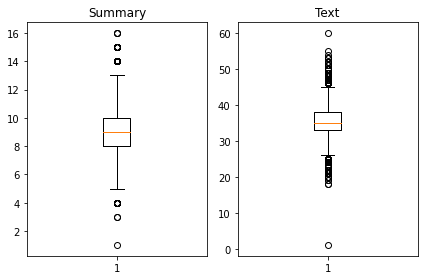

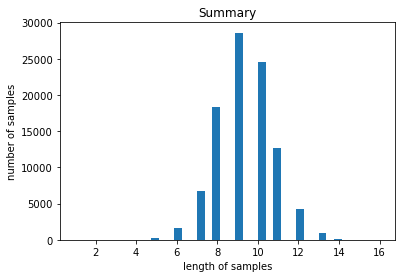

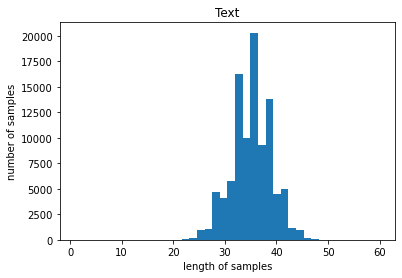

In [22]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## Text,Summary의 적절한 최대 길이를 임의로 정하기
위의 시각화된 정보를 통해서 적절한 최대 길이를 정한다.

In [23]:
text_max_len = 45
summary_max_len = 12

text_min_len = 22
summary_min_len = 6

## 문장 길이에 대한 데이터 비율 파악하기
 - 길이의 비율 보여주는 함수 생성 
 - 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 샘플길이 안에 속하는지 계산하는 함수이다

### 길이의 비율 보여주는 함수 생성 

In [24]:
# 길이의 비율 보여주는 함수 생성
# 데이터에서 특정 길이이하인 값의 비율을 보여주는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [25]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967745217745217
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880341880341881


각각 45, 12로 패딩을 하게되면 해당 길이보다 긴 샘플들은 내용이 잘라야된다.   
```
Text는     0.04%    내용이 망가진다.
summary는  0.12%    내용이 망가진다.
```

## 정해진 길이보다 길면 제외

```
   -> 96792

```

In [26]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 96792


## 시작 토큰과 종료 토큰 추가하기
디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈춘다.    
```
시작 토큰 SOS = start of a sequence   
종료 토큰 EOS = end of a sequence  
```

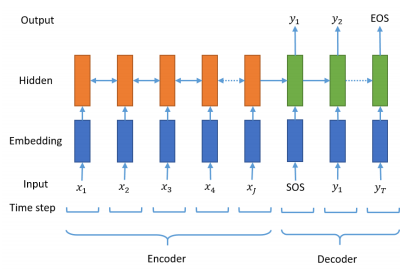

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가한다.

이번 실습에서는 시작 토큰 :'sostoken' 종료 토큰 : 'eostoken'으로 설정

디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정함

두 개의 문장 모두 Summary 열로부터 만들것이다.

In [29]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Summary,Text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


## numpy 값으로 변경
 인코더의 입력(decoder_input), 디코더의 입력(decoder_target)과 레이블을 각각 다시 Numpy 타입으로 저장한다.

In [30]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

## 훈련 데이터와 테스트 데이터를 분리

훈련 데이터와 테스트 데이터를 분리방법   
1) 패키지 사용   
2) 직접 하기   
우리는 2번째 방법인 직접 분리한다.
```
indices = np.arange(encoder_input.shape[0])
 -> encoder_input의 크기 만듬의 np.array만들기
np.random.shuffle(indices)
 -> indices에 순차적으로 들어간 값을 뒤죽박죽 섞어준다.

```

In [31]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[92450  6012 63537 ...  4599 39374 79492]


이 정수 시퀀스(indices)를 이용해 다시 데이터의 샘플 순서를 정의한다

In [34]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

### 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리하기   
전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의한다.   

In [35]:
n_of_val = int(len(encoder_input)*0.2) #총 데이터의 80%
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19358


#### 분리된 데이터 출력

In [36]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 77434
훈련 레이블의 개수 : 77434
테스트 데이터의 개수 : 19358
테스트 레이블의 개수 : 19358


# Step 1. 데이터 수집하기(3)정수 인코딩
- 단어 집합(vocaburary) 만들기
- 정수 인코딩


## 단어 집합(vocaburary) 만들기
- 각 단어는 고유한 정수로 맵핑하는 작업이 이루워져야된다.왜냐하면 컴퓨터가 처리할수 있는 데이터(숫자)로 변환해줘야기 때문에이다.이 과정을 단어 집합(vocaburary)을 만드는 과정이다.


## 훈련데이터 단어집합 만들기(encoder_input_train)

In [37]:
#Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있어요. 
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

```
현재 생성된 단어 집합의수 = src_tokenizer.word_index
```

## 생성된 단어집합 들여보기
만든 단어 집합에 있는 모든 단어를 사용하지 않는다.빈도수가 낮은 단어들은 훈련 데이터에서 제외한다.등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자
```
src_tokenizer.word_index         => 현재 생성된 단어 집합의수 
src_tokenizer.word_counts.items() => 단어와 각 단어의 등장 빈도수가 저장

이를 통해서 통계적인 정보를 얻을 수 있어요.
```


In [38]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69069
등장 빈도가 6번 이하인 희귀 단어의 수: 47104
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21965
단어 집합에서 희귀 단어의 비율: 68.19846819846819
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5167673840038556


## 등장 빈도가 6번 이하읜 희귀 단어를 단어 집합에서 제거
- 단어 집합의 크기를 69069-47104 = 21965으로 설정한다.
- encoder_input_train에는 총 32,017개
- 단어집합에서 threshold 값인 6회 이하의 값들이 68% 이상을 차지
- 실제로 훈련 데이터에 차지하는 비중은 3.51% 차지(낮은수치)

#### 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있어요.

In [39]:
src_vocab = 21965
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 2,1965으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성."

#### texts_to_sequences()
- 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 인코딩을 한다.
- 단어의 정수 인코딩 개수는 2,1965개 넘기 않도록 설정한다.(현재 단어 집합의 크기를 2,1965으로 제한했으니까)

In [40]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2321, 1900, 541, 445, 2526, 237, 89, 3, 417, 983, 4195, 8454, 21, 347, 8, 974, 5040, 222, 618, 13688, 3338, 737, 1564, 510, 1505, 6, 68, 445, 224, 359, 3577, 389, 3338, 737], [134, 3146, 4828, 7733, 18206, 14667, 1355, 7002, 5941, 19240, 85, 170, 10, 299, 84, 253, 142, 54, 30, 1241, 1490, 731, 3535, 13244, 1279, 161, 63, 418, 1098, 1482, 6, 1666, 991], [682, 669, 3995, 117, 1142, 18, 129, 6001, 342, 8, 599, 1444, 77, 4196, 1166, 3007, 2267, 479, 1142, 402, 3362, 599, 1174, 384, 93, 18, 18, 6001, 599, 3219]]


## 훈련데이터 단어집합 만들기(decoder_input_train)
 - Summary 데이터에 대해서도 동일한 작업을 수행

In [44]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

## 생성된 단어집합 들여보기
만든 단어 집합에 있는 모든 단어를 사용하지 않는다.빈도수가 낮은 단어들은 훈련 데이터에서 제외한다.등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자
```
tar_tokenizer.word_index         => 현재 생성된 단어 집합의수 
tar_tokenizer.word_counts.items() => 단어와 각 단어의 등장 빈도수가 저장

이를 통해서 통계적인 정보를 얻을 수 있다.
````

In [45]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29871
등장 빈도가 5번 이하인 희귀 단어의 수: 19550
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10321
단어 집합에서 희귀 단어의 비율: 65.44809346858158
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.71723543727232


## 등장 빈도가 5번 이하인 희귀 단어를 단어 집합에서 제거
단어 집합의 크기를 29871-19550 = 10321으로 설정한다.(10000으로)    
encoder_input_train에는 총 10,321개    
단어집합에서 threshold 값인 5회 이하의 값들이 65% 이상을 차지    
실제로 훈련 데이터에 차지하는 비중은 4.71% 차지(낮은수치)    

In [46]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 663, 2086, 1442, 530, 1363, 5, 23, 655], [1, 2291, 6, 1628, 5569, 4, 1337, 419], [1, 353, 3, 158, 531, 49, 871, 7170, 5, 631, 2592], [1, 1084, 2942, 883, 1062, 15, 177, 414, 7, 283, 59], [1, 945, 3, 6128, 2812, 1501, 8, 1021, 4336, 3292, 4, 244]]
target
decoder  [[663, 2086, 1442, 530, 1363, 5, 23, 655, 2], [2291, 6, 1628, 5569, 4, 1337, 419, 2], [353, 3, 158, 531, 49, 871, 7170, 5, 631, 2592, 2], [1084, 2942, 883, 1062, 15, 177, 414, 7, 283, 59, 2], [945, 3, 6128, 2812, 1501, 8, 1021, 4336, 3292, 4, 244, 2]]


## (인코딩후) 훈련,테스트에 대한 요약문 empty(빈 샘플)  경우 삭제 
- decoder_input에는 sostoken 추가되었고, decoder_target에는  eostoken 추가 되었다. 그래서 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스(empty빈 샘플)를 각각 drop_train과 drop_test에 라는 변수에 저장후 모두 삭제

In [47]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77434
훈련 레이블의 개수 : 77434
테스트 데이터의 개수 : 19358
테스트 레이블의 개수 : 19358


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


빈 샘플이 없으므로 삭제할 값도 없다.

## 패딩하기
아까 정해두었던 최대 길이로 패딩을 할것이다. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰준다.

In [48]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

전처리 끝

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.


## 인코더 설계(seq2seq와 동일)

In [50]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의했어요. hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터에요. 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴론의 갯수라고 이해하면 돼요. 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니에요.

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였어요. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있죠. 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야겠죠?

## 디코더 설계
디코더 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야된다.

In [51]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [52]:
# 디코더의 출력층
#decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
#decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 


# 모델 정의
#model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
#model.summary()

위의 주석된 코드는 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq방법이다. 

디코더의 출력층을 설계만 수정하면 바로 어텐션 메커니즘를 사용할수 있다.


참고사항    
디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제이다. 그래서 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있다

## 어텐션 매커니즘

어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야한다는 뜻이다.
이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 결합하자

아래의 코드를 수행하여 깃허브에 공개되어져 있는 어텐션 함수를 다운로드하자

In [53]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

이제 경로에 attention.py 파일이 생겼으니, 어텐션 메커니즘을 사용할 준비가 되었어요. 설계한 디코더의 출력층을 다음과 같이 수정할게요.

In [54]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 45, 128)      2811520     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 45, 256), (N 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

위의 코드는 인코더의 hidden state, 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있다.

## 모델 훈련하기

In [56]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
303/303 [==============================] - 112s 369ms/step - loss: 5.6070 - val_loss: 5.2061
Epoch 2/50
303/303 [==============================] - 110s 362ms/step - loss: 5.0430 - val_loss: 4.8109
Epoch 3/50
303/303 [==============================] - 113s 374ms/step - loss: 4.6776 - val_loss: 4.5184
Epoch 4/50
303/303 [==============================] - 113s 372ms/step - loss: 4.4074 - val_loss: 4.3233
Epoch 5/50
303/303 [==============================] - 114s 376ms/step - loss: 4.2016 - val_loss: 4.1862
Epoch 6/50
303/303 [==============================] - 116s 382ms/step - loss: 4.0301 - val_loss: 4.0717
Epoch 7/50
303/303 [==============================] - 115s 380ms/step - loss: 3.8860 - val_loss: 3.9860
Epoch 8/50
303/303 [==============================] - 113s 372ms/step - loss: 3.7614 - val_loss: 3.9042
Epoch 9/50
303/303 [==============================] - 110s 363ms/step - loss: 3.6503 - val_loss: 3.8494
Epoch 10/50
303/303 [==============================] - 112s 368m

- EarlyStopping은 한국어로 해석 하면 '조기 종료'의 뜻을 가지고 있는데, 특정 조건이 충족되면 모델의 훈련을 멈추는 역할한다.
- val_loss(검증 데이터의 손실)을 모니터링 하면서, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이patiensce =2 2회 관측되면 학습을 멈추도록 설정

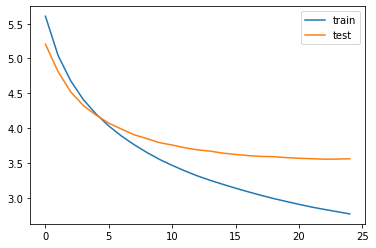

In [58]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 모델 구현하기
위의 훈련단계와 달리 테스트 단계에서는 정수 인덱스 행렬로 존재하던 데이터를 실제 텍스트 데이터로 복원해야한다.밑과 필요한 3개의 사전을 미리 준비한다.

In [59]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

훈련 단계에서는 디코더의 입력부분에 정답 문장 전체를 한번에 넣고, 디코더의 출력과 한번에 비교 할수 있으므로, 인코더와 디코더를 하나의 모델로 표현할수 있었다.

허나 정답 문장이 없는 인퍼런스(추정) 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계한다.

### 인코더 설계(인퍼런스 모델)

In [60]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

### 어텐션 메커니즘을 사용하는 출력층을 설계(인퍼런스 모델)

In [61]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

## 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 만들기
decode_sequence(input_seq)

In [62]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 모델 테스트하기

정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 만든다.
Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외시키고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외 시킨다.

In [63]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.   
테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

In [98]:
for i in range(50, 500):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : spice girls spokesperson confirmed five members pop band reuniting work new opportunities comes band members victoria beckham emma brown spotted together london reportedly accepted crore promote earlier songs along endorsements 
실제 요약 : all five members of girls to reunite 
예측 요약 :  hyd school gets its own dress for the theatres


원문 : year old japanese man died monday eighth attempt climb mount everest becoming second casualty climbing season found dead sleeping camp tent feet feet mountain lost nine one previous failed 
실제 요약 : japanese man dies on th attempt to climb mount everest 
예측 요약 :  year old dies after falling into everest


원문 : chief election commissioner nasim zaidi announced future elections country held using voter verified paper audit trail machines along electronic voting machines move comes amid series allegations political parties including mayawati bsp arvind kejriwal aap voting machines tampered elections 
실제 요약 : all future polls to be held with paper trail 

예측 요약 :  kerala hc issues ban on nipah virus outbreak


원문 : responding question issue potholes bengaluru press conference karnataka cm siddaramaiah said siddaramaiah even asked journalist raised question suggest actions take later asserted instructed city civic body make city roads pothole free within fortnight 
실제 요약 : what can we do says karnataka cm when asked about potholes 
예측 요약 :  taka cm slams media for calling people


원문 : australia committed troops help us case conflict north korea nuclear programme nation media called suicidal act inviting disaster australia participation military drills us left country open unspecified counter measures justice north korea state media added 
실제 요약 : australia support to us is suicidal act north korea 
예측 요약 :  us to send to korea after nuclear test


원문 : college student assam seriously injured youth reportedly college poured acid monday family reportedly refused marriage proposal back police registered case launched hunt nab accused stati

예측 요약 :  sc slams for not getting married to caste marriages


원문 : confession journalist gauri lankesh murder accused claimed hindu samiti leader mohan gowda put touch extremist unit hindu outfit sanatan sanstha planning murder came contact hindutva activist another accused arrested earlier may lankesh shot dead bengaluru september last year 
실제 요약 : journo murder accused names hindu body leader in confession 
예측 요약 :  gauri lankesh murder suspect suspect in gauri lankesh murder


원문 : actor rajkummar rao seen holding evm machine running away new poster upcoming film newton poster captioned aadmi directed amit masurkar film revolves around government clerk election duty naxal controlled town scheduled release august 
실제 요약 : rajkummar runs away with evm machine in new newton poster 
예측 요약 :  rajkummar rao to launch poster of rajkummar rao on poster


원문 : hollywood actor mark ruffalo known playing marvel comics superhero hulk said chances another standalone hulk movie mark added unive

예측 요약 :  gold worth lakh seized in delhi metro


원문 : vodafone group ceo letter telecom minister manoj sinha said telecom industry regulated based new ambition said move reduce mobile termination charge risks destroying companies built industry also sought reduction interest rate deferred spectrum payment 
실제 요약 : rules should not suit new vodafone ceo 
예측 요약 :  airtel to be probed for new rules for new rules chidambaram


원문 : government tuesday doubled import duty many textile products boost local production india total textile imports jumped record billion last fiscal billion china government increased import duty products including fibre last month 
실제 요약 : govt doubles import tax on products to 
예측 요약 :  govt to buy india for billion in china


원문 : slamming union budget presented government thursday congress president rahul gandhi tweeted years gone fancy schemes matching budgets added centre failed provide employment youth last four years bjp rule referring upcoming general elec

예측 요약 :  shilpa shetty shilpa shetty files defamation case against


원문 : rare instance homegrown billion dollar startup opting venture debt shopclues raised crore venture debt innoven capital fresh capital comes months shopclues entered billion dollar valuation league raising million last year debt good instrument meet working capital requirement achieve profitability said ceo sanjay sethi 
실제 요약 : raises cr in venture debt from capital 
예측 요약 :  us based debt raises million in debt


원문 : government common services centres sell patanjali products offer cash deposit facilities pay aadhaar linked payment system products would sold village level entrepreneurs working access points villages host government services provided 
실제 요약 : govt common services centres to sell patanjali products 
예측 요약 :  govt to sell up to refund for lakh


원문 : tesla ceo elon musk friday said automaker model become world first production electric car travel km single charge run took hours complete driver kept 

예측 요약 :  world champ beats world no champion to reach world ships


원문 : rare footage white taking dip sweden province gone viral social media reportedly white country makes sighting rare notably sweden per square kilometre country total population lakh 
실제 요약 : rare white in sweden 
예측 요약 :  video of white house goes on white house


원문 : telecom commission tuesday approved proposal allowing phone calls internet service flights within indian airspace telecom regulator trai recommended making calls allowed aircraft reaches altitude metres government intervene pricing mechanism would left airlines flight connectivity providers 
실제 요약 : flights to get internet calling service as govt clears plan 
예측 요약 :  trai seeks to use air india to fight air india


원문 : finance minister arun jaitley thursday lauded national investigation agency cracking dangerous terrorist module adding would possible without interception electronic communications nia conducted searches locations delhi uttar pradesh

예측 요약 :  scientists discover new solar system


원문 : telangana woman allegedly sold newborn girl help sweeper could raise due poverty lady bought girl claimed offered amount woman son treatment ill police registered case mother lady sweeper 
실제 요약 : woman sells her newborn girl for due to poverty 
예측 요약 :  woman gives birth to baby boy from selling home


원문 : pakistan rangers stationed india pakistan border wagah posed trophy icc world cup pakistan cricket board tweeted usual exercise unusual guest edition icc world cup scheduled hosted england wales may july 
실제 요약 : pakistani at wagah border pose with wc trophy 
예측 요약 :  pakistan pakistan to win pakistan in pakistan


원문 : chief election commissioner op rawat said wednesday election commission hold general election elections states simultaneously december said would problem parliamentary elections advanced mizoram assembly term end december madhya pradesh chhattisgarh rajasthan january 
실제 요약 : can hold general election with state p

예측 요약 :  esha deol shares first picture of her baby birth


원문 : un review country human rights record geneva philippines president rodrigo duterte ally senator alan peter claimed new wave killings prompted philippines war drugs however another filipino senator de lima told un cannot easily fooled like paid trolls cyberspace 
실제 요약 : no killings here philippines during un review 
예측 요약 :  un prez calls for human rights in human rights


원문 : former captain mahendra singh dhoni led india victories test matches successful indian test captain dhoni followed former captain sourav ganguly led india test wins matches year old retired tests december played tests scoring runs dismissals 
실제 요약 : no captain has led india to more test wins than ms dhoni 
예측 요약 :  dhoni india captain india to win in odi cricket


원문 : actor sidharth malhotra said wonders never linked co star film brothers akshay kumar adding feel bad akshay earlier sidharth linked female co stars films including alia bhatt jacque

예측 요약 :  arctic ice ice may be used by arctic ice study


원문 : nato supreme allied commander claimed russia may supplying taliban insurgents fight us nato forces afghanistan said seen russian influence growing afghan taliban earlier john us commander nato forces afghanistan accused russia giving diplomatic cover taliban undermine us influence defeat nato 
실제 요약 : russia may be supplying the taliban top nato commander 
예측 요약 :  us supreme leader to destroy us troops in syria


원문 : newly released footage shows year old united airlines passenger david arguing law enforcement officers forcibly drag overbooked flight heard repeating going threatening file lawsuit united officers say drag replies well drag go 
실제 요약 : new video shows moments before man dragged off united flight 
예측 요약 :  united airlines employee dragged off plane for hrs


원문 : blast armed men libyan crude oil pipeline tuesday reduced north african country crude oil output lakh barrels per day libya national oil company sai

예측 요약 :  got actor got my career got my career


원문 : ekta kapoor shared picture father jeetendra th birthday friday instagram ekta mother shobha kapoor also seen picture fathers build daughters build nation biggest strength read caption alongside picture jeetendra known films like among others 
실제 요약 : ekta kapoor shares pic with on his th birthday 
예측 요약 :  kareena shares pic with daughter rishi kapoor daughter


원문 : first australia based team led indian researcher srinivasan shown bees preference left right like humans flying obstacles bees displayed side bias whereas half remaining preferred left gap half preferred right bees preferred wider gaps narrow 
실제 요약 : bees can be or like humans study 
예측 요약 :  australia to play everest in the world


원문 : talking product development early stages makemytrip founder ceo deep kalra recent interview said first years tough adding outsourcing technology company terrible mistake said took good part years bring technology 
실제 요약 : first five ye

예측 요약 :  prez kovind to hold over non veg in public


원문 : drunk man allegedly seat woman passenger onboard air india new york new delhi flight indrani ghosh daughter passenger tweeted incident revealing mother travelling alone completely traumatised minister state civil aviation jayant sinha responded ghosh ordered probe incident 
실제 요약 : drunk man on woman seat in air india flight 
예측 요약 :  drunk man who molested in air india flight arrested


원문 : scientists examining world known fossils rex skin neck tail suggested dinosaur reptile like skin finding contrary researchers claim rex researchers said dinosaur ancestors lost feathers time longer needed insulation 
실제 요약 : rex skin fossils suggest it was not 
예측 요약 :  scientists identify new species that can detect


원문 : asia honda motor president abe said though company gaining market share india motorcycle segment long way go reach hero launched similar models really difficult change mindset consumer stated never give abe said adding 

예측 요약 :  australia to build space for space in space


원문 : pm narendra modi sunday said world ease business central government talks ease living congress government karnataka talks ease murder addressing rally poll bound karnataka pm modi also said people oppose ruling congress state end losing lives 
실제 요약 : taka cong govt talks ease of doing murder pm modi 
예측 요약 :  pm modi to stop india gdp from government


원문 : bjp mp rp sharma daughter pallavi sharma government officers arrested connection assam public service commission cash job scam earlier police identified officers batch bribed officials get jobs doctored answer scripts many officers arrested case far 
실제 요약 : bjp mp daughter arrested in assam cash for job scam 
예측 요약 :  bjp mp daughter to give funds to help corruption victims


원문 : punjab haryana high court tuesday issued show cause notice home secretaries punjab haryana located respective states court hearing petition asking state governments implement orders regular basi

예측 요약 :  nawazuddin slams nawazuddin for wife over sexual harassment


원문 : speaking protests sanjay leela bhansali directorial padmavati producer photographer atul said become religious god vulnerable mine problem subject film watch added atul said padmavati essentially fictitious character 
실제 요약 : is your god so vulnerable mine on padmavati row 
예측 요약 :  will not be used to hide body on padmavati row


원문 : salil year old indian former tesla employee charged allegedly stealing million carmaker allegedly used role send money owed one supplier another supplier posing employee taiwanese supplier clear whether benefitted alleged scheme 
실제 요약 : indian who worked at tesla charged for stealing cr from company 
예측 요약 :  tesla worker who stole his own house to buy his employee


원문 : brazilian woman born without vagina become world first patient undergo surgery using fish skin declared successful year procedure involved creation inserting genital shaped mould lined skin fish fish skin absor

예측 요약 :  ex congress leader to get married in karnataka


원문 : technology company blackberry launched cloud based software cybersecurity product called detect vulnerabilities software used connected autonomous vehicles automakers online access scan number binary files every stage software development also applicable industries including healthcare blackberry said 
실제 요약 : blackberry makes to spot flaws in self driving cars 
예측 요약 :  startup makes phone that can charge users for


원문 : indian cricketer rohit sharma praised england captain joe root gesture distributing letters around england fans whose hotel bookings kandy cancelled accommodate england sri lanka teams root wrote letter one english supporters meeting lunch second day test match express sympathy 
실제 요약 : rohit praises root letters to eng fans with cancelled bookings 
예측 요약 :  rohit sharma gets jersey from wearing shorts to wear


원문 : india first mission mars mars orbiter mission successfully completed three years orbit de

예측 요약 :  hc allows up to implement test for neet


원문 : indian gymnast dipa karmakar pulled women artistic gymnastics final asian games due knee injury suffered event indonesia dipa injury occurred landing practice session ahead participation women qualification team finals tuesday 
실제 요약 : injured dipa pulls out of gymnastics final at asiad 
예측 요약 :  indian team wins silver at wimbledon race


원문 : interview us president donald trump cbs news sunday people noticed painting past presidents hanging white house featured former us presidents abraham lincoln ronald reagan richard nixon others dining trump painting went viral artist andy thomas revealed titled republican club 
실제 요약 : people spot trump painting with past us presidents in interview 
예측 요약 :  trump accuses wh of his statue of fame


원문 : supreme court asked centre bring law fixing liability people could prosecuted made pay compensation case loss life assets court suggested setting mechanism wherein one district judges could t

예측 요약 :  muslims should be given to muslims union minister


원문 : gst tax rates cut items including refrigerators water washing machines vacuum cleaners small screen tvs shifted slab sanitary napkins rakhis idols made stone marble wood exempted footwear costing attract gst earlier 
실제 요약 : which items will become cheaper after gst rate cut 
예측 요약 :  gst council approves water on day of water on july


원문 : minister state social justice empowerment ramdas athawale slapped man event maharashtra saturday police officials confirmed incident happened athawale leaving event accused thrashed athawale supporters later taken custody identified pravin 
실제 요약 : union minister slapped at maharashtra event 
예측 요약 :  union minister orders to get security


원문 : lok sabha adjourned day wednesday following protests opposition members congress mps shouted slogans held placards demanding joint parliamentary committee probe alleged corruption rafale deal shiv sena mps staged protests demanding immediate 

예측 요약 :  never thought am to get my life madhuri madhuri


원문 : pointing father salim khan muslim mother hindu actor salman khan said calls speaking hindustan times leadership summit added religion industry earlier asked state religion salman said indian 
실제 요약 : my dad is muslim mother hindu call myself salman 
예측 요약 :  no one of the tej pratap on kader khan


원문 : trailer upcoming science fiction film star wars last jedi eighth instalment star wars series released film late actress carrie fisher final film series also stars daisy ridley john mark directed johnson film scheduled release december 
실제 요약 : trailer of star wars the last released 
예측 요약 :  trailer of ayushmann starrer released


원문 : slamming amitabh bachchan commenting kathua rape case actor prakash raj said requested said want speak prakash added talking party talking issue kathua case pertains rape eight year old muslim girl allegedly drugged gangraped killed group men 
실제 요약 : prakash raj slams big for not speaking on

예측 요약 :  cong leader alleges cong workers in taka to get corruption


원문 : month old girl allegedly sexually assaulted father friend delhi jat monday accused girl parents siblings home incident happened police said girl mother returned found crying bleeding private parts took hospital 
실제 요약 : month old girl raped by father friend in delhi 
예측 요약 :  year old girl raped by neighbour in delhi


원문 : adelaide strikers batsman jonathan wells slammed metre six landed roof sydney cricket ground thursday six came bowling sydney sixers pacer ben last innings seen hit shane warne many many years ago said ricky ponting commentating 
실제 요약 : batsman slams metre six ball lands on roof of 
예측 요약 :  player jumps off to bat on ground after run out


원문 : girl tamil nadu argued supreme court national eligibility cum entrance test score used sole basis medical admissions killed friday reportedly depressed neet based cbse syllabus court refused exempt tamil nadu neet 
실제 요약 : tn girl who against neet in

예측 요약 :  astronaut shares first ever image of space station


원문 : day second india windies government monday renamed lucknow international cricket stadium bharat ratan shri atal bihari vajpayee cricket stadium would first international cricket match played stadium india defeated windies first take lead three match series 
실제 요약 : lucknow stadium renamed after vajpayee day before india wi 
예측 요약 :  india first odi ton came to india squad for day


원문 : us president donald trump misspelled word healing twitter user wrote heel wife shoes heal long time leave office users wrote dumb every single day 
실제 요약 : twitter mocks trump for the word healing 
예측 요약 :  trump slams twitter over tweet on her


원문 : election commission issued notice gandhinagar archbishop thomas wrote letter catholic community warning nationalist forces stating gujarat assembly elections could make difference alleging democratic fabric india stake letter claimed growing sense insecurity among minorities 
실제 요약 : ec not

예측 요약 :  delhi cop son arrested for daughter picture with daughter


원문 : year old man arrested raping year old girl uttar pradesh abducted girl pretext offering lift following assaulted abandoned toll plaza passerby later found crying helped reached bus station relatives picked 
실제 요약 : man held for raping year old girl in up 
예측 요약 :  year old raped by man in front of raping year old


원문 : disruptions demonetisation events surrounding implementation gst led setback india economic momentum said world bank report added growth expected slowdown according bank gst expected disrupt economic activity early momentum pick 
실제 요약 : note ban gst caused to indian economy world bank 
예측 요약 :  gst rate to be in india says it is bad


원문 : complex finland luxury glass allow guests staying inside glass feature kitchen air conditioning bathroom facilities wi fi beds adjusted various positions premium cost per night superior start per night 
실제 요약 : there are luxury glass in complex in finland 
예측 요

생각보다 성능이 좋지 않다. 성능을 올리는방법으로    
1)seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법     
2)빔 서치(beam search)    
3)사전 훈련된 워드 임베딩(pre-trained word embedding), 또는 인코더 - 디코더 자체의 구조를 새로이 변경하는 트랜스포머(Transformer)    
등 여러가지 개선 방안이 존재한다고 한다.    

# Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

## 데이터 다시 받기

## 패키지 설치
```
$ pip install summa
```

In [65]:
import requests
from summa.summarizer import summarize

```
text (str) : 요약할 테스트.
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
words (int or None, optional) – 출력에 포함할 단어 수.
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환
```
- Summa의 summarize는 가공없이 원문을 바로 사용한다(함수인지에 넣어주면 내부적으로 문장 토큰화를한다.)


#### 요약문이 나오지 않는다.

In [100]:
# 기사글을 줘도 요약문이 나오지 않는다.
print('Summary:')
print(summarize(data_original['text'][0], ratio=0.005))

Summary:



## 추출적 요약 안되는 이유   
[내 생각]
1. 제공되는 텍스트의 단어가 부족하다.

2. 전처리된 텍스트 사용했기 때문에   
data 데이터는 전처리가 적용된 데이터이다. Summa을 이용해서 추출적 요약을 하기위해서는 전처리 전의 원본의 data를 사용해야한다.

#### 추출적 요약과 추상적 요약 결과를 비교하려면????     
이번 프로젝트에서 작성한 추상적인 요약모델의  코드에서 데이터를 섞어주는 부분이 존재한다. 이부분을 생각하며 추가적인 코드작업을 해야할것이다.

##  뉴스text중 임의의 데이터를 추출적 요약해보자(추상적요약과 비교X)

## 전처리전 데이터 사용

In [90]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data_original = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 96792


In [218]:
data['headlines'].head(5)

0    upGrad learner switches to career in ML & Al w...
1    Delhi techie wins free food from Swiggy for on...
2    New Zealand end Rohit Sharma-led India's 12-ma...
3    Aegon life iTerm insurance plan helps customer...
4    Have known Hirani for yrs, what if MeToo claim...
Name: headlines, dtype: object

#### ratio,words값 조절

In [212]:
print('원본:',data_original['text'][0],'\n')
print('요약:',summarize(data_original['text'][0], ratio=0.5,words=13))

원본: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers. 

요약: upGrad's Online Power Learning has powered 3 lakh+ careers.


In [217]:
print('원본:',data_original['text'][1],'\n')
print('요약:',summarize(data_original['text'][1], ratio=0.5,words=13))

원본: Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more. 

요약: Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


# 질문
```
1.(전처리단계)텍스트 정규화와 불용어 제거 무엇인가?   
정규화와 불용어는 정확히는 다르다. 정규화작업은 is not => isn`t 처럼 통일화 시켜주는 작업이고, 불용어 제거는 문법적 사용되지만 의미적으로 사용되지 않는 단어를 제거하는것이다.



2.(전처리단계)노드에서는 text칼럼의 중복 만 제거하고 headline(Summary)는 중복 제거 안했다.나는 2개의 칼럼에 대한 중복를 제거 하였다. [의문] 어떤 방법이 효율적일까?
-> text칼럼의 중복제거는 무조건 해줘야된다. Summary중복제거는 그때마다 틀릴것같다.(내 생각)
'summary는 라벨 역할을 하기때문에 중복를 삭제할 필요가 없다.' 라고 생각하였다. 여기서 내가 이해한것은 Text를 보고 행을 제거한다면 중복된 summary값들도 제거된다고 이해하였다.허나 text가 달라도 summary는 동일할수 있다. 동일하다는것은 다른 단어라도 같은 요약문을 나타낼수도 있지 않는가 의문이 든다. 허나 summary가 최종 값인데 그 최종 문장이 중복된다면 이상할 수도 있다. 그러니 많은 훈련데이터가 있다면  Summary중복제거해도 결과에는 차이가 없을거라 생각된다. 그리니 두 컬럼의 중복을 제거해주자. 

3.(전처리단계)문장의 최대 길이을 지정하는 이유
  노드에서 최대 길이를 지정하는 이유는 패딩을 할때 text의 값이 잘려 나가는 것을 방지 하기 위함이다. 지정된 최대 길이보다 큰 경우는 text목록에서 제거 해준다. 


4.(전처리단계)문장의 길이의 최대길이를 정하였다. 그러면 최소 길이도 정해서 작업해도 괜찮지 않을까?
 노드 초반에 생각난 방식이다. 문장길이를 이상치 그래프로 제공하여서 최소길이에 대한 값도 제거 해줘야된다는?? 착각에 빠진것같다. 우리가 문장길이에 대한 이상치를 찾는 이유는 텍스트를 패딩시 텍스트값이 망가지는가를 확인하는것이기때문에 최소길이에 대한 작업은 안해도 된다.
 

4.'인퍼런스 모델 구현하기 모델'은 무엇인가


5. 추출적 요약을 하는 경우에는 오직 text칼럼만 사용한다. 왜?
 -> 직접 추출적요약 코드를 작성한다면 둘다 text, Summary칼럼이 둘다 필요할것이다. 이번 프로젝트에서 추출적 요약할때  라이브러리Summa를 사용하였다. 이 라이브러리 사용법이 text를 넣어주면 알아서 추출적요약을 해주기 때문이다.
 
6.추출적 요약 안되는 이유[내 생각]
1)제공되는 텍스트의 단어가 부족하다.
2)전처리된 텍스트 사용했기 때문에
data 데이터는 전처리가 적용된 데이터이다. Summa을 이용해서 추출적 요약을 하기위해서는 원래의 data를 사용해야한다. 그렇다면 전처리전의 data를 summa로 추출적 요약 결과와 코드로 작성한 추상적 요약결과를 비교해야한다. 어려운점이 프로젝트에서는 데이터를 섞어주는 작업을 하여서 특정 원문을 몇 행있는지 모른다. 즉 추가적인 코드작업을 해야 파악이 가능하다.
   

7. time step의 셀에 hidden state뿐만 아니라, cell state이 무엇인가?
   
8. RNN은 학습 데이터의 길이가 길어질수록 먼 과거의 정보를 현재에 전달하기 어렵다는 문제가 있다. 이 문제를 해결하기 위해 LSTM과 GRU가 등장했고, 이 둘도 부족해서 어텐션(Attention) 메커니즘이 등장했지요.이 문제의 이름은 무엇인가요?
장기 의존성(long term dependencies) 문제


```

# 배운 개념

### 텍스트 요약(Text Summarization)
- 긴 길이의 문서(Document)원문을 핵심 주제만으로 구성된 짧은 요약(summary)문장들로 변환하는 작업
- 요약문은 문서 원문의 문장의 의미를 최대한 보존해야 한다.

### 추출적 요약(Extractive Summarization)
- 문서에서 문장들을 추출해서 요악하는 방식   
 ex)10개의 문장으로 구성된 문서가 있을때, 그중 핵심적인 문장 3개를 추출한다.    
- 추출한 문장을 그대로 연결하면 부자연스럽다. 이때 자연스럽게 해주는 머신 러닝 방식인 있다.텍스트랭크와 같은 알고리즘을 사용한다고 한다.   
 ex) 대표적인 것 네이버 뉴스서비스(요약본)    

- 원문의 문장 중 무엇을 요약문에 들어간 핵심 문장인지 판별한다는 점에서 문장 분류(Text Classification)로 볼수 있다.

### 추상적 요약(Abstractive Summarization)
- 원문에 원래 없던 새로운 문장을 생성한다.(원문의 핵심내용을 가진 문장)
- 자연어 생성NLG(Natural Language Generation)의 방식


### seq2seq
- 인코더와 디코더의 구조로 구성된 이 딥 러닝 아키텍처
- seq2seq은 두 개의 RNN 아키텍처를 사용하여 입력 시퀀스로부터 출력 시퀀스를 생성해내는 자연어 생성 모델

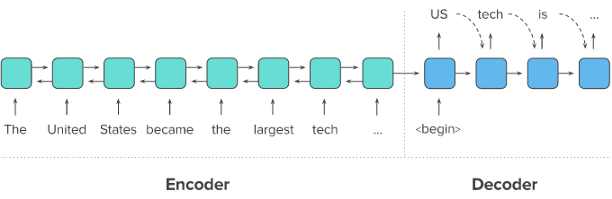
첫번째 RNN인 인코더로 입력하면, 인코더는 이를 하나의 고정된 벡터로 변환한다. 이 벡터를 문맥 정보를 가지고  하여 컨텍스트 벡터(context vector)라고 한다. 두번째 RNN인 디코더는 이 컨텍스트 벡터를 전달받아 한 단어씩 생성해내서 요약문장을 완성한다.

-원문을 RNN인 인코더에 넣으면 컨텍스트 벡터(context vector) 나옴
-두번째 RNN인 디코더는 이 컨텍스트 벡터를 전달받아 한 단어씩 생성해내서 요약 문장을 완성한다.

''

### seq2seq에서 인코더와 디코더를 LSTM 설정한다.

LSTM이 바닐라 RNN과 다른 점은 time step의 셀에 hidden state뿐만 아니라, cell state도 함께 전달한다.   
즉 인코더가 디코더에 전달하는 컨텍스트 벡터 또한 hidden state(h)와 cell state(c) 값 두개가 존재 해야된다. 

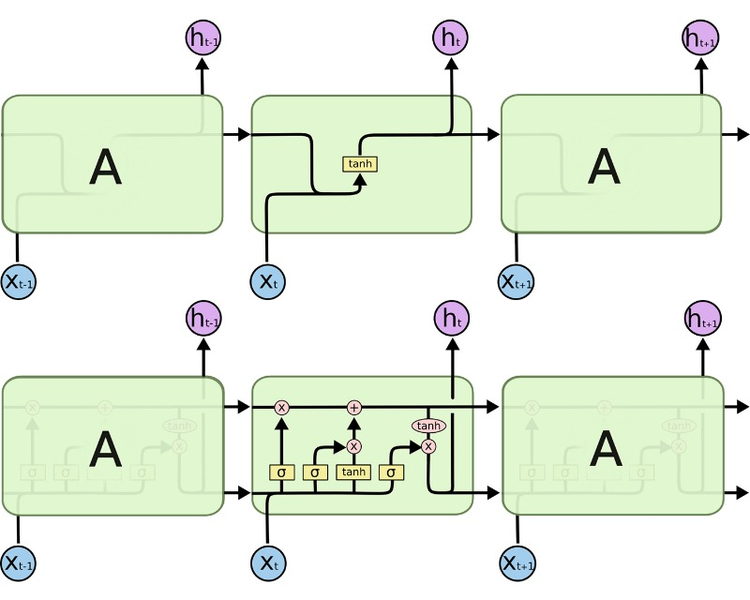

### 시작 토큰과 종료 토큰  용도
seq2seq 구조에서 디코더는 시작 토큰 SOS가 입력되면, 각 시점마다 단어를 생성하고 이 과정을 종료 토큰 EOS를 예측하는 순간까지 멈추지않는다. 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈춘다.

시작 토큰 SOS = start of a sequence   
종료 토큰 EOS = end of a sequence  

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가한다.

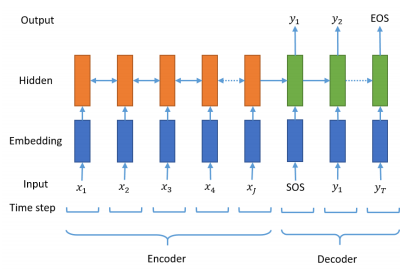

### 어텐션 메커니즘(Attention Mechanism)     
인코더의 모든 step의 hidden state의 정보가 컨텍스트 벡터에 전부 반영되도록 하는 것입니다. 하지만 인코더의 모든 hidden state가 동일한 비중으로 반영되는 것이 아니라, 디코더의 현재 time step의 예측에 인코더의 각 step이 얼마나 영향을 미치는지에 따른 가중합으로 계산되는 방식입니다.

자세한 내용은 밑 유투트,사이트 참조
유투브영상 : https://www.youtube.com/watch?v=WsQLdu2JMgI      
딥 러닝을 이용한 자연어 처리 입문(위키독스) : https://wikidocs.net/48948


### 어텐션 seq2seq 동작 순서
1.seq2seq를 사용합니다.
2.RNN 계열 중 LSTM을 사용하므로 hidden state뿐만 아니라 cell state도 사용해야 합니다.
3.디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙입니다.
4.seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측을 시작합니다.
5.seq2seq 기본 모델과 달리, 어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산합니다.
6.계산된 컨텍스트 벡터를 이용해서 디코더는 다음 등장할 단어를 예측합니다.

#### 구글 인공지능 "뉴스 제목도 잘 뽑네"
https://zdnet.co.kr/view/?no=20160905114833&from=Mobile

   
#### RNN에서 은닉층에서 활성화 함수를 통해 결과를 내보내는 역할을 하는 노드를 셀(cell)이라고 합니다.https://wikidocs.net/22886  

#### [딥러닝 기계번역] 시퀀스 투 시퀀스 + 어텐션 모델
https://www.youtube.com/watch?v=WsQLdu2JMgI

In [1]:
더 수정해야된다.

SyntaxError: invalid syntax (<ipython-input-1-6d80dfedd406>, line 1)